In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
class LinearBlock(nn.Module):
    def __init__(self,in_dim,out_dim,dropout):
        super().__init__()
        self.fc = nn.Linear(in_dim,out_dim)
        self.bn = nn.BatchNorm1d(out_dim)
        self.ac = nn.SELU()
        self.dp = nn.Dropout(p=dropout)
        
    def forward(self,x):
        x = self.fc(x)
        x = self.bn(x)
        x = self.ac(x)
        x = self.dp(x)
        
        return x

In [4]:
class MLP(nn.Module):
    def __init__(self,in_dim, h_dims, out_dim, dropout):
        super().__init__()
        dims = [in_dim] + list(h_dims)
        layers = []
        for i in range(len(h_dims)):
            layers.append(LinearBlock(dims[i],dims[i+1],dropout))
        
        self.layers = nn.Sequential(*layers)
        
        self.outfc = nn.Linear(h_dims[-1],out_dim)
        
    def forward(self,x):
        x = self.layers(x)
        return self.outfc(x)

In [5]:
def train_val_test_split(X, y, train_size, val_size, random_seed=2022):
    assert X.shape[0] == y.shape[0]
    inds = np.arange(X.shape[0])
    
    np.random.seed(random_seed)
    np.random.shuffle(inds)
    
    spl1 = int(train_size*X.shape[0])
    spl2 = int(val_size*X.shape[0])
    
    train_inds = inds[:spl1]
    val_inds   = inds[spl1:spl1+spl2]
    test_inds  = inds[spl1+spl2:]
    
    X_train, y_train = X[train_inds,:], y[train_inds,:]
    X_val,   y_val   = X[val_inds,:],   y[val_inds,:]
    X_test, y_test = X[test_inds,:], y[test_inds,:]
    
    train_tds = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    val_tds   = TensorDataset(torch.Tensor(X_val),   torch.Tensor(y_val))
    test_tds  = TensorDataset(torch.Tensor(X_test),  torch.Tensor(y_test))
    
    return train_tds,val_tds,test_tds

### Create dataloaders

In [6]:
n_samples = 100
n_features = 30
n_out_dim = 10

In [7]:
X = np.random.randn(n_samples,n_features)

In [8]:
X.shape

(100, 30)

In [9]:
Y = nn.Linear(n_features,n_out_dim)(torch.Tensor(X)).detach().numpy()

In [10]:
Y.shape

(100, 10)

In [11]:
train_tds,val_tds,test_tds = train_val_test_split(X, Y, 0.7, 0.15, random_seed=2022)

In [12]:
len(train_tds), len(val_tds), len(test_tds)

(70, 15, 15)

In [13]:
train_loader = DataLoader(train_tds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_tds,batch_size=32, shuffle=True)

### Create model

In [14]:
h_dims = [20,20] # two hidden layers, with 20 nodes each

In [15]:
model = MLP(n_features, h_dims, n_out_dim,dropout=0.1)

In [16]:
model

MLP(
  (layers): Sequential(
    (0): LinearBlock(
      (fc): Linear(in_features=30, out_features=20, bias=True)
      (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ac): SELU()
      (dp): Dropout(p=0.1, inplace=False)
    )
    (1): LinearBlock(
      (fc): Linear(in_features=20, out_features=20, bias=True)
      (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (ac): SELU()
      (dp): Dropout(p=0.1, inplace=False)
    )
  )
  (outfc): Linear(in_features=20, out_features=10, bias=True)
)

### Train model with early stop

In [17]:
lr = 0.001
max_epochs = 1000

In [18]:
train_loss = []
val_loss = []

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()

In [21]:
best_val_loss = np.inf
patience = 10
early_stop = False

In [22]:
for epoch in range(max_epochs):
    if early_stop: break
    model.train()
    
    epoch_train_loss = []
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        loss = loss_fn(model(x),y)
        loss.backward()
        optimizer.step()
        
        epoch_train_loss.append(loss.detach().item())
    
    train_loss.append(np.mean(epoch_train_loss))
    
    # validation
    epoch_val_loss = []
    with torch.no_grad():
        model.eval()
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)
            
            loss = loss_fn(model(x),y)
            epoch_val_loss.append(loss.detach().item())
    
    val_loss.append(np.mean(epoch_val_loss))
    
    # check if to early stop training
    if val_loss[-1] < best_val_loss:
        best_val_loss = val_loss[-1]
        waited_epochs = 0
        
    else:
        waited_epochs += 1
        if waited_epochs > patience: early_stop = True

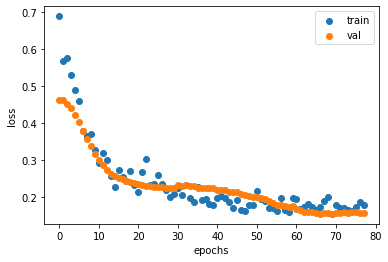

In [30]:
plt.scatter(np.arange(len(train_loss)),train_loss, label='train')
plt.scatter(np.arange(len(val_loss)),val_loss,label='val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [31]:
X_test, y_test = test_tds.tensors

In [32]:
test_loss = loss_fn(model(X_test),y_test)

In [33]:
test_loss

tensor(0.1869, grad_fn=<MseLossBackward>)